# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
# !pip install implicit


In [2]:
# !unzip /data/retail_train.csv.zip -d /data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


In [7]:
recommender.get_als_recommendations(2375, N=200)[:10]

[1037863,
 981760,
 923746,
 899624,
 845208,
 1000753,
 835300,
 844179,
 934639,
 863447]

In [8]:
recommender.get_own_recommendations(2375, N=200)[:10]

[1085983,
 1036501,
 1079023,
 847962,
 950935,
 828370,
 945652,
 1015474,
 913745,
 986021]

In [9]:
recommender.get_similar_items_recommendation(2375, N=200)[:10]

[9396821,
 5568378,
 878636,
 1004906,
 845208,
 953675,
 981086,
 1127831,
 9527160,
 1133018]

In [10]:
recommender.get_similar_users_recommendation(2375, N=200)[:10]

[9802981,
 905436,
 985605,
 5569376,
 820923,
 1092945,
 974548,
 1915708,
 822517,
 1070803]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [12]:
# your_code

In [13]:
result_train_lvl_1 = data_train_lvl_1.groupby('user_id')['item_id'].unique().reset_index()

In [14]:
test_users = result_lvl_1.shape[0]
train_users = result_train_lvl_1.shape[0]
new_test_users = len(set(result_lvl_1['user_id']) - set(result_train_lvl_1 ['user_id']))

print('В тестовом датасете {} юзеров'.format(test_users))
print('В обучающем датасете {} юзеров'.format(train_users))
print('В тестовом датасете {} новых юзеров'.format(new_test_users))

В тестовом датасете 2154 юзеров
В обучающем датасете 2493 юзеров
В тестовом датасете 5 новых юзеров


In [15]:
# удалим холодных юзеров из тестового датасета
result_lvl_1 = result_lvl_1[result_lvl_1['user_id'].isin(data_train_lvl_1.user_id.unique())]

In [16]:
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply\
                                    (lambda x: recommender.get_als_recommendations(x, N=200))
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply\
                                    (lambda x: recommender.get_own_recommendations(x, N=200))
result_lvl_1['similar_items_recommendations'] = result_lvl_1['user_id'].apply\
                                    (lambda x: recommender.get_similar_items_recommendation(x, N=200))
#result_lvl_1['similar_users_recommendation'] = result_lvl_1['user_id'].apply\
##                                    (lambda x: recommender.get_similar_users_recommendation(x, N=200))

In [17]:
result_lvl_1.head(2)

,user_id,actual,als_recommendations,own_recommendations,similar_items_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1045586, 958046, 1025641, 1004390, 5569374, 8...","[856942, 9297615, 5577022, 9655212, 8090541, 9...","[885023, 999999, 9526410, 5582712, 9420181, 65..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[880150, 12518330, 9834988, 12262830, 974306, ...","[911974, 1076580, 1056620, 1083296, 850601, 66...","[1106523, 5569845, 819978, 8090537, 880888, 84..."


In [18]:
kk = [20, 50, 100, 200, 500]

all_recommendations = result_lvl_1.iloc[:,2:].columns
all_rec_df = pd.DataFrame(index=kk, columns=all_recommendations)

for rec in all_recommendations:
    for k in kk:
        recall_value = result_lvl_1.apply(lambda row: recall_at_k(row[rec], row['actual'], k=k), axis=1).mean()
        all_rec_df.loc[k, rec] = recall_value



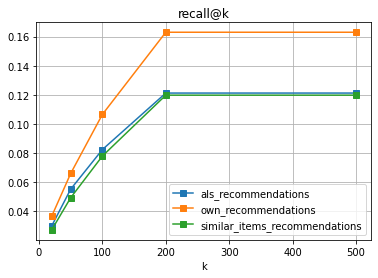

In [19]:
all_rec_df.plot(marker='s')
plt.title('recall@k')
plt.xlabel('k')
plt.grid(True)
plt.show()

own recommendtions + top-popular дают лучший recall  
До k=200 recall растет, далее нет.  
Наиболее разумным является значение k=200 (в данном случае)  
У нас датасет не большой, мощности компьютера должно хватить

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [20]:
# your_code

In [21]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [22]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [23]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


==================================

In [24]:
als_recommendations = result_lvl_1[['user_id', 'als_recommendations']]

In [25]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})

In [26]:
valid_lvl_2 = valid_lvl_2.merge(als_recommendations, on='user_id', how='left')

In [27]:
valid_lvl_2[valid_lvl_2.als_recommendations.notna()].\
apply(lambda row: precision_at_k(row['als_recommendations'], row['actual'], k=5), axis=1).mean()

0.10397489539748901

=====================================

In [28]:
result_lvl_1['als_recommendations'] = result_lvl_1.apply(lambda row: precision_at_k(row['als_recommendations'], row['actual'], k=50), axis=1)

item features

In [29]:
data_train_lvl_2['price'] = data_train_lvl_2['sales_value'] / (np.maximum(data_train_lvl_2['quantity'], 1))

In [30]:
# Фичи товаров
## Средняя цена товара, Средняя цена товара по категории, Средняя цена товара по sub категории

prices = data_train_lvl_2.groupby(['item_id'])['price'].mean()
prices.name='item_mean_price'
item_features = item_features.merge(prices, on='item_id', how='left')

commodity_desk = item_features.groupby(['commodity_desc'])['item_mean_price'].mean()
commodity_desk.name = 'commodity_mean_price'
item_features = item_features.merge(commodity_desk, on='commodity_desc', how='left')

sub_commodity_desc = item_features.groupby(['sub_commodity_desc'])['commodity_mean_price'].mean()
sub_commodity_desc.name = 'sub_commodity_mean_price' 
item_features = item_features.merge(sub_commodity_desc, on='sub_commodity_desc', how='left')

In [31]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_mean_price,commodity_mean_price,sub_commodity_mean_price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,NaN,1.872979,1.872979
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,NaN,5.247452,5.247452


In [32]:
# Фичи юзера
## 1) общая сумма покупок 2) общее количество покупок

popular = data.groupby('user_id')['sales_value'].sum().reset_index() #общая сумма покупок
user_features = user_features.merge(popular, on='user_id')
user_features.rename(columns={'sales_value': 'sales_value_user'}, inplace=True)


count_sales = data.groupby('user_id')['quantity'].count().reset_index() #общее количество покупок 
user_features = user_features.merge(count_sales, on='user_id')
user_features.rename(columns={'quantity': 'quantity_sum_user'}, inplace=True)


user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,sales_value_user,quantity_sum_user
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,3959.91,1589
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,2865.89,1072


In [33]:
# фичи для пары юзер-товар
## 




In [34]:
user_item_feat = data_train_lvl_2[['user_id', 'item_id', 'basket_id', 'quantity', 'sales_value', 'week_no']]
user_item_feat = user_item_feat.merge(item_features, on=['item_id'], how='left')
user_item_feat = user_item_feat.merge(user_features, on=['user_id'], how='left')

In [35]:
# Отношение суммы покупок за неделю совершенных юзером к сумме за неделю всего по категории
# Отношение суммы покупок за неделю совершенных юзером к средней сумме за неделю всего по категории

user_sales_value_week = user_item_feat.groupby(['user_id', 'department', 'week_no']).agg({'sales_value' : 'sum'})\
                  .reset_index().rename(columns={'sales_value' : 'user_sales_value_week'})

sales_value_week = user_item_feat.groupby(['department', 'week_no']).agg({'sales_value' : 'sum'})\
                  .reset_index().rename(columns=({'sales_value' : 'sales_value_week'}))

mean_sales_value_week = user_item_feat.groupby(['department', 'week_no']).agg({'sales_value' : 'mean'})\
                  .reset_index().rename(columns=({'sales_value' : 'mean_sales_value_week'}))

result = user_sales_value_week.merge(sales_value_week, on=['department', 'week_no'], how='left')
result = result.merge(mean_sales_value_week, on=['department', 'week_no'], how='left')
result['sum_purchases_user_to_week'] = result['user_sales_value_week'] / result['sales_value_week']
result['sum_purchases_user_to_mean_week'] = result['user_sales_value_week'] / result['mean_sales_value_week']

user_item_feat = user_item_feat.merge(result[['user_id', 'department', 'sum_purchases_user_to_week', \
                                              'sum_purchases_user_to_mean_week']], on=['user_id', 'department'], how='left')
user_item_feat.head(2)

,user_id,item_id,basket_id,quantity,sales_value,week_no,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_mean_price,commodity_mean_price,sub_commodity_mean_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,sales_value_user,quantity_sum_user,sum_purchases_user_to_week,sum_purchases_user_to_mean_week
0,2070,1019940,40618492260,1,1.0,86,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,1.0,2.661363,2.638144,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,6981.86,2415.0,0.000365,6.652164
1,2070,1019940,40618492260,1,1.0,86,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,1.0,2.661363,2.638144,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,6981.86,2415.0,0.001609,29.805666


In [36]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users2 = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users2)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [37]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[834103, 1119399, 1107824, 5570513, 934131, 10..."
1,2021,"[950935, 1119454, 835578, 1019142, 1051489, 10..."


In [38]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,834103,1
0,2070,1119399,1
0,2070,1107824,1
0,2070,5570513,1


In [39]:
users_lvl_2.shape[0]

429800

In [40]:
users_lvl_2['user_id'].nunique()

2149

In [41]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [42]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0


In [43]:
targets_lvl_2['target'].mean()

0.07111188187267678

In [44]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
user_item_features = user_item_feat[['user_id', 'item_id', 'sum_purchases_user_to_week', 'sum_purchases_user_to_mean_week']]
targets_lvl_2 = targets_lvl_2.merge(user_item_features, on=['user_id', 'item_id'], how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_mean_price,commodity_mean_price,sub_commodity_mean_price,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,sales_value_user,quantity_sum_user,sum_purchases_user_to_week,sum_purchases_user_to_mean_week
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.0,2.661363,2.660197,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,6981.86,2415.0,0.000365,6.652164
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,1.0,2.661363,2.660197,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,6981.86,2415.0,0.001609,29.805666


In [45]:
targets_lvl_2.columns

Index(['user_id', 'item_id', 'target', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'item_mean_price', 'commodity_mean_price', 'sub_commodity_mean_price',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'sales_value_user', 'quantity_sum_user', 'sum_purchases_user_to_week',
       'sum_purchases_user_to_mean_week'],
      dtype='object')

In [46]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [47]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'item_mean_price',
 'commodity_mean_price',
 'sub_commodity_mean_price',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'sales_value_user',
 'quantity_sum_user',
 'sum_purchases_user_to_week',
 'sum_purchases_user_to_mean_week']

In [48]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=20, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CPU times: user 39.9 s, sys: 136 ms, total: 40 s
Wall time: 21.2 s


In [49]:
train_preds

array([1., 1., 1., ..., 0., 0., 0.])

In [50]:
targets_lvl_2['preds'] = train_preds

In [51]:
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)

In [52]:
lgb_recommendations = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()

In [53]:
lgb_recommendations.head(5)

,user_id,item_id
0,1,[856942]
1,2,"[1035843, 1106523, 1029743]"
2,4,"[908283, 962229, 1029743, 1106523]"
3,6,[1119051]
4,7,"[1029743, 995242, 1106523]"


In [54]:
valid_lvl_2 = valid_lvl_2.merge(lgb_recommendations, on='user_id', how='left')

In [55]:
valid_lvl_2.rename(columns={'item_id': 'lgb_recommendations'}, inplace=True)

In [56]:
valid_lvl_2[valid_lvl_2.lgb_recommendations.notna()].\
apply(lambda row: precision_at_k(row['lgb_recommendations'], row['actual'], k=5), axis=1).mean()

0.29631276150627595

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)